# Imports and load data

In [1]:
import csv
import gzip
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

import scanorama
from sklearn.preprocessing import normalize

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

import hotspot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline

overwrite=False

set_seed(123)

N_PCS_SEURAT = 30
N_PCS_SCAN = 100

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='1'

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
# sc.set_figure_params(figsize=(4, 4))
sns.set(context="notebook", font_scale=1.3, style="ticks")
# sns.set(style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

In [3]:
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_111 = anndataset_111[anndataset_111.obs["batch_indices"] == 0]
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")
anndataset_206 = anndataset_206[anndataset_206.obs["batch_indices"] == 1]
anndataset_206.obs["batch_indices"] -= 1

Trying to set attribute `.obs` of view, making a copy.


In [4]:
keep_pro_111 = [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
keep_pro_206 = [not (p.startswith("HTO") or p.startswith("ADT_Isotype")) for p in anndataset_206.uns["protein_names"]]

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][:, keep_pro_111]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][:, keep_pro_206]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

In [5]:
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values

[2020-04-24 15:07:42,121] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:07:42,124] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:07:42,186] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:07:42,248] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells
[2020-04-24 15:07:42,680] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:07:42,683] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:07:42,741] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:07:42,790] INFO - scvi.dataset.dataset | Downsampled from 7105 to 7105 cells


In [6]:
dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206])

[2020-04-24 15:07:42,948] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-04-24 15:07:43,074] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:07:43,170] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:07:43,173] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:07:43,276] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:07:43,363] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:07:43,365] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:07:43,734] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:07:43,736] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:07:43,738] INFO - scvi.dataset.dataset | Keeping 110 columns in protein_expression


In [7]:
# standard log library size normalize RNA and concatenate log transformed protein
full_data = dataset.X
norm_full_data = anndata.AnnData(X=full_data)
sc.pp.normalize_per_cell(norm_full_data, counts_per_cell_after=1e4)
sc.pp.log1p(norm_full_data)
norm_full_data = anndata.AnnData(
    X=np.concatenate(
        [
            norm_full_data.X,
            np.log1p(dataset.protein_expression),
        ],
        axis=1,
    )
)
col_names = np.concatenate([dataset.gene_names, dataset.protein_names])
norm_full_data.var_names = col_names

# Run models

In [8]:
datasets = [dataset_111, dataset_206, dataset]
models = []
trainers = []
names = ["SLN_D1_111", "SLN_D2_206", "SLN_harmo_intersect"]

for d in datasets:
    if d.n_batches > 1:
        m = TOTALVI(d.nb_genes, d.protein_expression.shape[1], n_latent=20, n_batch=d.n_batches, encoder_batch=True)
    else:
        m = TOTALVI(d.nb_genes, d.protein_expression.shape[1], n_latent=20)
    models.append(m)
    use_cuda = True
    lr = 4e-3
    early_stopping_kwargs = {
        "early_stopping_metric": "elbo",
        "save_best_state_metric": "elbo",
        "patience": 45,
        "threshold": 0,
        "reduce_lr_on_plateau": True,
        "lr_patience": 30,
        "lr_factor": 0.6,
        "posterior_class": TotalPosterior,
    }
    
    trainer = TotalTrainer(
        m,
        d,
        train_size=0.90,
        test_size=0.10,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory":False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainers.append(trainer)
totalvae_111, totalvae_206, totalvae = models[0], models[1], models[2]

In [9]:
if overwrite is True:
    for t, n in zip(trainers, names):
        t.train(lr=lr, n_epochs=500)
        torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")
else:
    for m, n, t in zip(models, names, trainers):
        try:
            m.load_state_dict(torch.load("saved_models/" + n + ".pt"))
            m.eval()
        except FileNotFoundError:
            t.train(lr=lr, n_epochs=500)
            torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")

In [10]:
# create posterior on full data
posteriors = []
latents = []
for t, m, d in zip(trainers, models, datasets):
    full_posterior = t.create_posterior(
        m, d, indices=np.arange(len(d)), type_class=TotalPosterior
    )
    posteriors.append(full_posterior)
    # extract latent space
    latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()
    latents.append(latent_mean)

In [11]:
post_adatas = []
if overwrite:
    for n in names:
        os.remove("saved_post_adata/" + n + ".h5ad")
for n in names:
    try:
            post_adatas.append(anndata.read_h5ad("saved_post_adata/" + n + ".h5ad"))
    except OSError:
        for d, l, n in zip(datasets, latents, names):
            post_adata = anndata.AnnData(X=d.X)
            post_adata.var.index = d.gene_names
            post_adata.obsm["X_totalVI"] = l
            sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=25, metric="correlation")
            sc.tl.umap(post_adata, min_dist=0.2)
            sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.8)
            post_adata.write("saved_post_adata/" + n + ".h5ad", compression="gzip")
            post_adatas.append(post_adata)
post_adatas[2].obs["batch_indices"] = [str(b[0]) for b in datasets[2].batch_indices]

## totalVI intersect UMAP

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'totalVI intersect' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


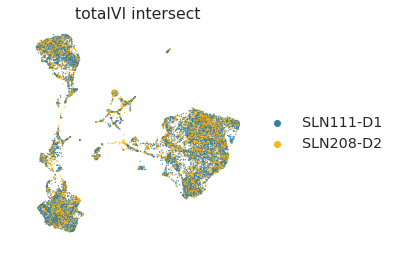

In [12]:
d_names = ["SLN111-D1", "SLN208-D2"]
post_adatas[2].obs["totalVI intersect"] = [d_names[int(b)] for b in datasets[2].batch_indices]
inds = np.random.permutation(np.arange(datasets[2].X.shape[0]))
fig = sc.pl.umap(
    post_adatas[2][inds], 
    color=["totalVI intersect"],
    ncols=1,
    alpha=0.9,
    return_fig=True,
    frameon=False
)
sns.despine(fig=fig)
fig.savefig("figures/totalVI_intersect_umap.pdf", dpi=DPI, bbox_inches='tight')

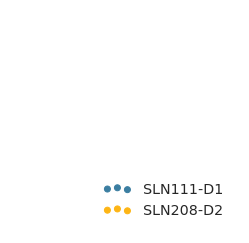

In [13]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(1, 1)
    ax.scatter([], [], label=d_names[0])
    ax.scatter([], [], label=d_names[1])
    ax.legend(frameon=False, scatterpoints=3, loc='lower right')
    sns.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([])
    fig.savefig("figures/intersect_legend.pdf", dpi=DPI)

In [14]:
parsed_pro_names = [s.split("_")[1].split("(")[0].split("-Er")[0] for s in dataset.protein_names]
for i, p in enumerate(parsed_pro_names):
    post_adatas[2].obs[p] = np.log1p(datasets[2].protein_expression[:, i])

... storing 'batch_indices' as categorical
... storing 'totalVI intersect' as categorical


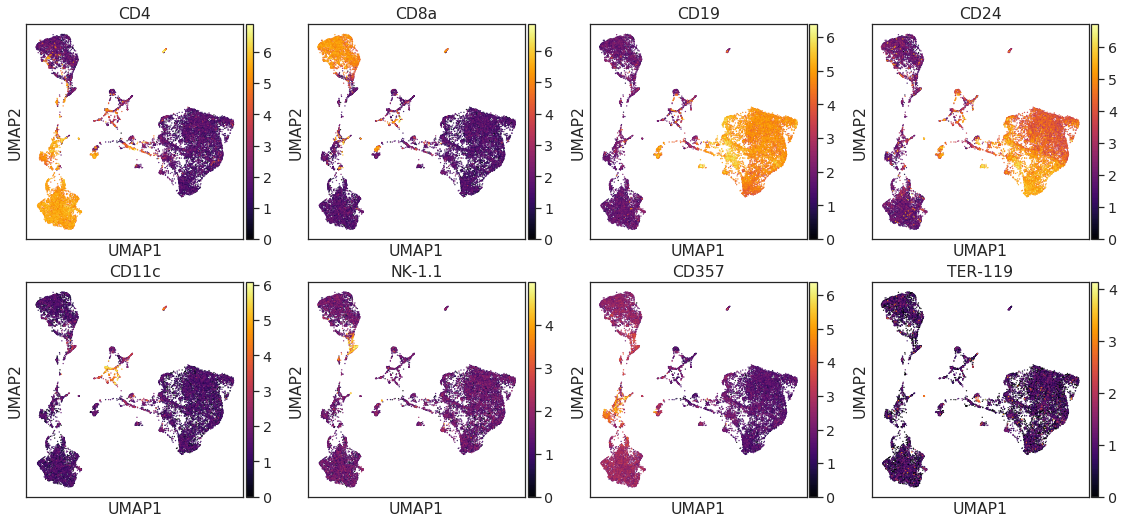

In [15]:
inds = np.random.permutation(np.arange(datasets[2].X.shape[0]))
fig = sc.pl.umap(
    post_adatas[2], 
    color=["CD4", "CD8a", "CD19", "CD24", "CD11c", "NK-1.1" ,"CD357", "TER-119"],
    alpha=0.9,
    return_fig=True,
    frameon=True,
    ncols=4,
    cmap="inferno",
    hspace=0.2,
    wspace=W_SPACE
)
# sns.despine(fig=fig)
fig.savefig("figures/totalVI_intersect_umap_w_proteins.pdf", dpi=DPI, bbox_inches='tight')

## Calculate mixing statistics

In [16]:
ENTROPY_K = 100
harmo_metrics = pd.DataFrame(
    index=["totalVI-intersect", "totalVI-union", "scanorama", "Seurat v3"],
    columns=["Mixing metric", "Hotspot metric"],
)
harmo_metrics["models"] = [
    "totalVI-intersect",
    "totalVI-union",
    "scanorama",
    "Seurat v3",
]

knn = np.ceil(len(dataset.X) * (np.arange(0.1, 1, 0.1)) / 100).astype(int)


In [17]:
harmo_metrics.loc["totalVI-intersect", "Mixing metric"] = entropy_batch_mixing(
    post_adatas[2].obsm["X_totalVI"], datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)

0.4340521717881361


In [18]:
harmo_metrics.loc["totalVI-intersect", "Hotspot metric"], _, _ = hotspot_score(
    norm_full_data,
    post_adatas[0].obsm["X_totalVI"],
    post_adatas[1].obsm["X_totalVI"],
    post_adatas[2].obsm["X_totalVI"],
    datasets[2].batch_indices.ravel(),
)

100%|██████████| 4115/4115 [00:01<00:00, 2564.09it/s]


53.4405771826955
16.299708312002824


# Scanorama

In [19]:
b = datasets[2].batch_indices.ravel()

# RNA is standard log normalized, protein just log transform
# Columns are standard scaled after
full_data = datasets[2].X
scan_adata = norm_full_data.copy()
sc.pp.scale(scan_adata)
col_names = np.concatenate([datasets[2].gene_names, datasets[2].protein_names])
scan_adata.X = normalize(scan_adata.X)
integrated, corrected, genes = scanorama.correct(
    [scan_adata.X[b == 0], scan_adata.X[b == 1]],
    [col_names, col_names],
    return_dimred=True,
)
integrated_cat = np.concatenate(integrated, axis=0)

Found 4115 genes among all datasets
[[0.         0.66450777]
 [0.         0.        ]]
Processing datasets (0, 1)


In [20]:
scan_adata.obsm["X_scan"] = integrated_cat
scan_adata.obs["Scanorama"] = [d_names[int(b)] for b in datasets[2].batch_indices]
sc.pp.neighbors(scan_adata, use_rep="X_scan", n_neighbors=20)
sc.tl.umap(scan_adata, min_dist=0.6)
sc.tl.leiden(scan_adata, key_added="leiden_scan", resolution=0.8)

In [21]:
harmo_metrics.loc["scanorama", "Mixing metric"] = entropy_batch_mixing(
    integrated_cat, datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)

0.4340521717881361


In [22]:
b = datasets[2].batch_indices.ravel()

scan_batch_0 = anndata.AnnData(norm_full_data.X[b == 0].copy())
sc.pp.scale(scan_batch_0)
scan_batch_0.X = normalize(scan_batch_0.X)
sc.tl.pca(scan_batch_0, n_comps=N_PCS_SCAN)

scan_batch_1 = anndata.AnnData(norm_full_data.X[b == 1].copy())
sc.pp.scale(scan_batch_1)
scan_batch_1.X = normalize(scan_batch_1.X)
sc.tl.pca(scan_batch_1, n_comps=N_PCS_SCAN)

In [23]:
harmo_metrics.loc["scanorama", "Hotspot metric"], hs_joint_1_results, hs_1_results = hotspot_score(
    norm_full_data,
    scan_batch_0.obsm["X_pca"],
    scan_batch_1.obsm["X_pca"],
    scan_adata.obsm["X_scan"],
    datasets[2].batch_indices.ravel(),
)

100%|██████████| 4115/4115 [00:01<00:00, 3335.15it/s]


23.213300420616942
15.649317392790813


Trying to set attribute `.obs` of view, making a copy.
... storing 'Scanorama' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


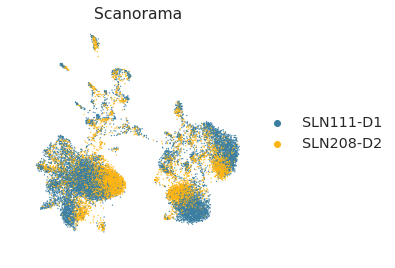

In [24]:
inds = np.random.permutation(np.arange(scan_adata.X.shape[0]))
fig = sc.pl.umap(
    scan_adata[inds], 
    color=["Scanorama"],
    ncols=1,
    alpha=0.9,
    return_fig=True,
    frameon=False,
)
sns.despine(fig=fig)
fig.savefig("figures/scanorama_umap.pdf", dpi=DPI, bbox_inches='tight')

In [25]:
for i, p in enumerate(parsed_pro_names):
    scan_adata.obs[p] = np.log1p(datasets[2].protein_expression[:, i])

... storing 'Scanorama' as categorical


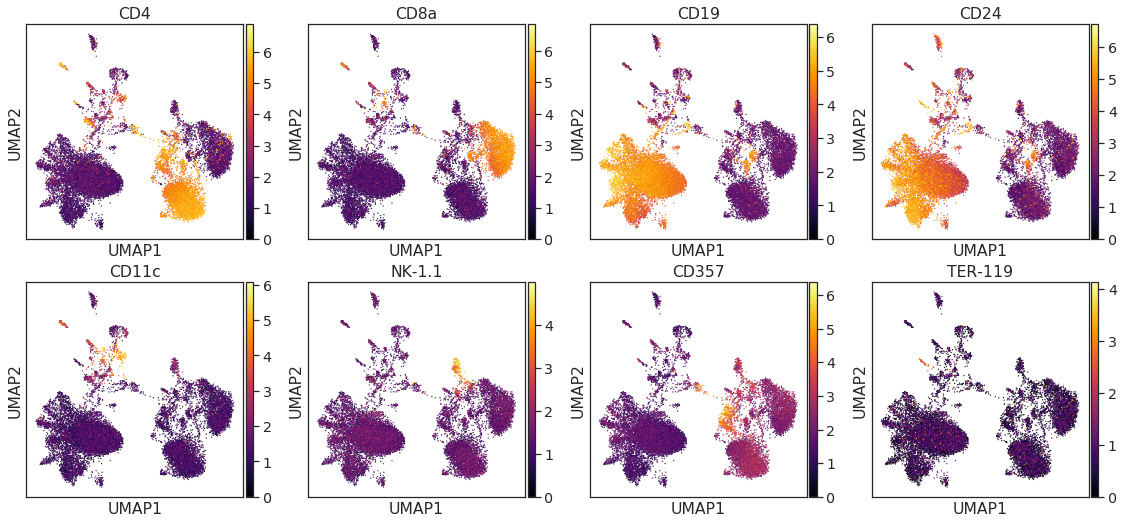

In [26]:
fig = sc.pl.umap(
    scan_adata, 
    color=["CD4", "CD8a", "CD19", "CD24", "CD11c", "NK-1.1" ,"CD357", "TER-119"],
    alpha=0.9,
    return_fig=True,
    frameon=True,
    ncols=4,
    cmap="inferno",
    hspace=0.2,
    wspace=W_SPACE
)
# sns.despine(fig=fig)
fig.savefig("figures/scanorama_umap_w_proteins.pdf", dpi=DPI, bbox_inches='tight')

# Seurat v3

In [27]:
write_seurat_data = False

b = datasets[2].batch_indices.ravel()

if write_seurat_data is True:
    batch_0_rna_pro = pd.DataFrame(
        norm_full_data.X[b == 0].T,
        index=col_names,
        columns=anndataset_111.obs.index,
        dtype=np.float32,
    )
    batch_1_rna_pro = pd.DataFrame(
        norm_full_data.X[b == 1].T,
        index=col_names,
        columns=anndataset_206.obs.index,
        dtype=np.float32,
    )
    save_path_csv = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/raw_data/"

    batch_0_rna_pro.to_csv(save_path_csv + "sln_d1_111_harmo_rna_pro.csv.gz")
    batch_1_rna_pro.to_csv(save_path_csv + "sln_d2_206_harmo_rna_pro.csv.gz")
    
seurat_results = pd.read_csv(
    "/data/yosef2/users/adamgayoso/projects/totalVI_journal/harmonization/seurat_harmo_results/seurat_d1_111_d2_206_integrated.csv.gz", 
    index_col=0,
).transpose()

In [28]:
adata_seurat = anndata.AnnData(seurat_results.values)
adata_seurat.obs["Seurat v3"] = [d_names[int(b)] for b in datasets[2].batch_indices]
sc.pp.scale(adata_seurat)
sc.tl.pca(adata_seurat, n_comps=N_PCS_SEURAT)
sc.pp.neighbors(adata_seurat, n_neighbors=20, n_pcs=N_PCS_SEURAT)
sc.tl.umap(adata_seurat)

In [29]:
b = datasets[2].batch_indices.ravel()

seurat_batch_0 = norm_full_data[b == 0].copy()
sc.pp.scale(seurat_batch_0)
sc.tl.pca(seurat_batch_0, n_comps=N_PCS_SEURAT)

seurat_batch_1 = norm_full_data[b == 1].copy()
sc.pp.scale(seurat_batch_1)
sc.tl.pca(seurat_batch_1, n_comps=N_PCS_SEURAT)

In [30]:
harmo_metrics.loc["Seurat v3", "Hotspot metric"], _, _ = hotspot_score(
    norm_full_data,
    seurat_batch_0.obsm["X_pca"],
    seurat_batch_1.obsm["X_pca"],
    adata_seurat.obsm["X_pca"],
    datasets[2].batch_indices.ravel(),
)

100%|██████████| 4115/4115 [00:03<00:00, 1282.36it/s]


3.666501768541036
9.404240958209224


In [31]:
harmo_metrics.loc["Seurat v3", "Mixing metric"] = entropy_batch_mixing(
    adata_seurat.obsm["X_pca"], datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)

0.4340521717881361


Trying to set attribute `.obs` of view, making a copy.
... storing 'Seurat v3' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


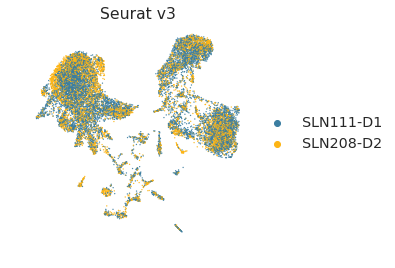

In [32]:
inds = np.random.permutation(np.arange(adata_seurat.X.shape[0]))
fig = sc.pl.umap(adata_seurat[inds], color="Seurat v3", alpha=0.9, return_fig=True, frameon=False)
sns.despine(fig=fig)
fig.savefig("figures/seurat_umap.pdf", dpi=DPI, bbox_inches='tight')

In [33]:
for i, p in enumerate(parsed_pro_names):
    adata_seurat.obs[p] = np.log1p(datasets[2].protein_expression[:, i])

... storing 'Seurat v3' as categorical


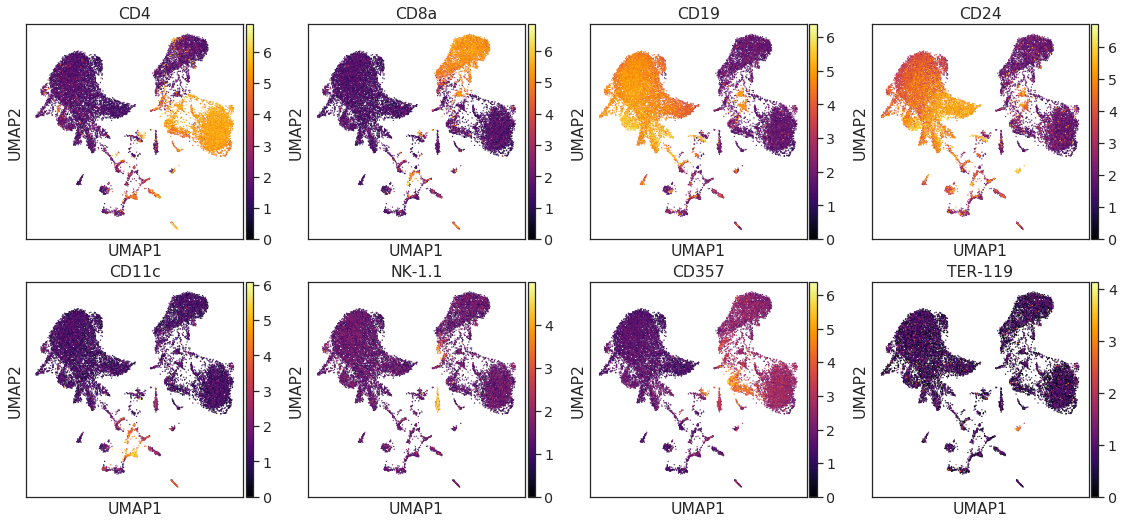

In [34]:
fig = sc.pl.umap(
    adata_seurat, 
    color=["CD4", "CD8a", "CD19", "CD24", "CD11c", "NK-1.1" ,"CD357", "TER-119"],
    alpha=0.9,
    return_fig=True,
    frameon=True,
    ncols=4,
    cmap="inferno",
    hspace=0.2,
    wspace=W_SPACE
)
# sns.despine(fig=fig)
fig.savefig("figures/seurat_umap_w_proteins.pdf", dpi=DPI, bbox_inches='tight')

# No correction

In [35]:
b = datasets[2].batch_indices.ravel()

no_bc_adata = norm_full_data.copy()
no_bc_adata.obs["No correction"] = [d_names[int(b)] for b in datasets[2].batch_indices]

In [36]:
# sc.pp.scale(no_bc_adata)
sc.tl.pca(no_bc_adata, n_comps=N_PCS_SEURAT)
sc.pp.neighbors(no_bc_adata, n_neighbors=20, n_pcs=N_PCS_SEURAT)
sc.tl.umap(no_bc_adata)

Trying to set attribute `.obs` of view, making a copy.
... storing 'No correction' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


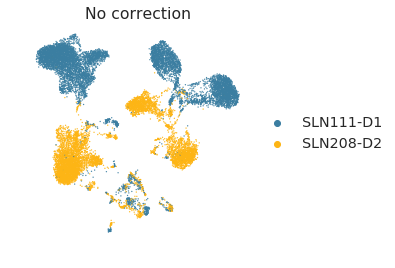

In [37]:
inds = np.random.permutation(np.arange(no_bc_adata.X.shape[0]))
fig = sc.pl.umap(no_bc_adata[inds], color="No correction", alpha=0.9, return_fig=True, frameon=False)
sns.despine(fig=fig)
fig.savefig("figures/no_correction_umap.pdf", dpi=DPI, bbox_inches='tight')

In [38]:
for i, p in enumerate(parsed_pro_names):
    no_bc_adata.obs[p] = np.log1p(datasets[2].protein_expression[:, i])

... storing 'No correction' as categorical


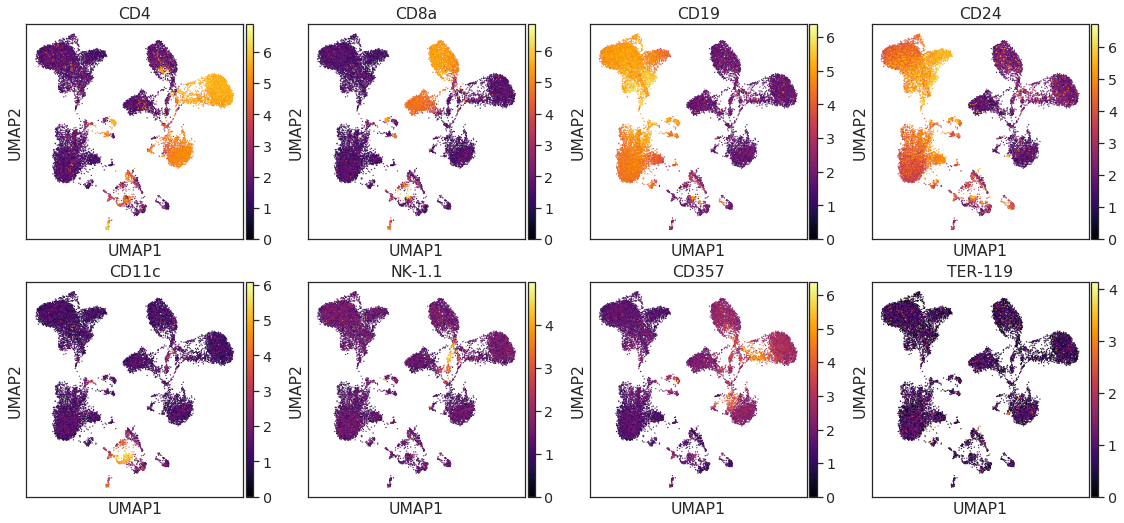

In [39]:
fig = sc.pl.umap(
    no_bc_adata, 
    color=["CD4", "CD8a", "CD19", "CD24", "CD11c", "NK-1.1" ,"CD357", "TER-119"],
    alpha=0.9,
    return_fig=True,
    frameon=True,
    ncols=4,
    cmap="inferno",
    hspace=0.2,
    wspace=W_SPACE
)

# Metrics

In [40]:
totalVI_union_stats = pd.read_csv("/data/yosef2/users/adamgayoso/projects/totalVI_journal/harmonization/misc_results/sln_d1_111_d2_206_union_stats.csv", index_col=0)
harmo_metrics.loc["totalVI-union"] = totalVI_union_stats.loc["totalVI-union"]

In [41]:
harmo_metrics

,Mixing metric,Hotspot metric,models
totalVI-intersect,-0.0328022,0.964414,totalVI-intersect
totalVI-union,-0.0280198,0.665524,totalVI-union
scanorama,-0.148159,-2.64658,scanorama
Seurat v3,-0.0568817,-0.174979,Seurat v3


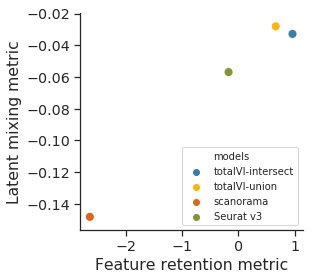

In [42]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.scatterplot(data=harmo_metrics, y="Mixing metric", x="Hotspot metric", hue="models", s=80, ax=ax)
    sns.despine()
    ax.legend(loc="lower right", prop={'size': 10}, fancybox=True)
    # ax.set_xlim(0.62, 0.82)
    ax.set_ylabel("Latent mixing metric")
    ax.set_xlabel("Feature retention metric")
    fig.savefig("figures/entropy_vs_retainment.pdf", bbox_inches="tight")

In [43]:
from scipy.sparse import vstack
scan_corrected = vstack(corrected).A
corrected

[<9264x4115 sparse matrix of type '<class 'numpy.float32'>'
 	with 38121360 stored elements in Compressed Sparse Row format>,
 <7105x4115 sparse matrix of type '<class 'numpy.float64'>'
 	with 29237075 stored elements in Compressed Sparse Row format>]

In [44]:
denoised_genes, denoised_proteins = posteriors[-1].sequential().get_normalized_denoised_expression(
    n_samples=50, give_mean=True, transform_batch=[0, 1], 
)

denoised_total = np.concatenate([denoised_genes, denoised_proteins], axis=-1)

In [45]:
from scipy.stats import mannwhitneyu

totalVI_Us = []
totalVI_p_vals = []
scan_Us = []
scan_p_vals = []
mnn_Us = []
mnn_p_vals = []
seurat_Us = []
seurat_p_vals = []
types = []
models = []
full_Us = []
full_ps = []
mannwhit = pd.DataFrame(columns=["Feature", "Mixing metric", "ps", "Method"])
batches = datasets[-1].batch_indices.ravel()
for i in range(denoised_total.shape[1]):
    if i < datasets[2].nb_genes:
        types.append("Gene")
    else:
        types.append("Protein")
    U, p_val = mannwhitneyu(
        denoised_total[batches == 0, i], denoised_total[batches == 1, i]
    )
    totalVI_Us.append(U)
    totalVI_p_vals.append(p_val)
    full_Us.append(U)
    full_ps.append(p_val)
    models.append("totalVI-intersect")
    
    if i < datasets[2].nb_genes:
        types.append("Gene")
    else:
        types.append("Protein")
    
    U, p_val = mannwhitneyu(
        scan_corrected[batches == 0, i], scan_corrected[batches == 1, i]
    )
    scan_Us.append(U)
    scan_p_vals.append(p_val)
    full_Us.append(U)
    full_ps.append(p_val)
    models.append("Scanorama")
    
    if i < datasets[2].nb_genes:
        types.append("Gene")
    else:
        types.append("Protein")
    
    U, p_val = mannwhitneyu(
        adata_seurat.X[batches == 0, i], adata_seurat.X[batches == 1, i]
    )
    seurat_Us.append(U)
    seurat_p_vals.append(p_val)
    full_Us.append(U)
    full_ps.append(p_val)
    models.append("Seurat v3")
    
mannwhit["Feature"] = types
mannwhit["Mixing Metric"] = full_Us
mannwhit["ps"] = full_ps
mannwhit["Method"] = models


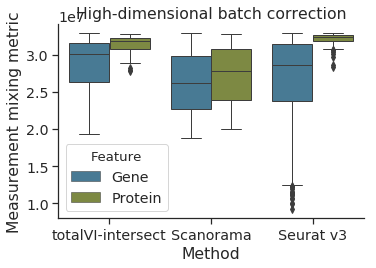

In [46]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(5.5, 4))
    box_colors = ["#3B7EA1", "#859438"]
    sns.boxplot(x="Method", y="Mixing Metric", hue="Feature", data=mannwhit, ax=ax, linewidth=1, palette=box_colors)
    sns.despine()
    ax.set_title("High-dimensional batch correction")
    ax.set_ylabel("Measurement mixing metric")
    plt.tight_layout()
    fig.savefig("figures/mann_whitney_u.pdf")